![logo](../../picture/license_header_logo.png)
> **Copyright &copy; 2020 - 2021 CertifAI Sdn. Bhd.**<br>
 <br>
This program and the accompanying materials are made available under the
terms of the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). <br>
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS, WITHOUT
WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the
License for the specific language governing permissions and limitations
under the License. <br>
<br>**SPDX-License-Identifier: Apache-2.0**

# Forecasting with Moving Averages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../../datasets/decomposition/AirPassengers.csv")
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In time series problem, it is important to check if the column that contains dates or time belongs to the `datetime` object.

In [3]:
df['Month']

0      1949-01
1      1949-02
2      1949-03
3      1949-04
4      1949-05
        ...   
139    1960-08
140    1960-09
141    1960-10
142    1960-11
143    1960-12
Name: Month, Length: 144, dtype: object

The `Month` column does not belong to `DateTime` object, lets turn it into the `datetime` object.

In [4]:
df['Month'] = pd.to_datetime(df['Month'])
df['Month']

0     1949-01-01
1     1949-02-01
2     1949-03-01
3     1949-04-01
4     1949-05-01
         ...    
139   1960-08-01
140   1960-09-01
141   1960-10-01
142   1960-11-01
143   1960-12-01
Name: Month, Length: 144, dtype: datetime64[ns]

It is now converted to the datetime object, let us set it as the index of the dataframe.

In [5]:
df.set_index("Month", inplace=True)

In [6]:
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


It is important that we check whether there's any missing values in our data.

In [7]:
df.isna().any().sum()

0

Luckily, there's no missing values in our dataset we will proceed to perform exploratory analysis.

## Exploratory analysis

The best visualization is to plot out the graph of the data.

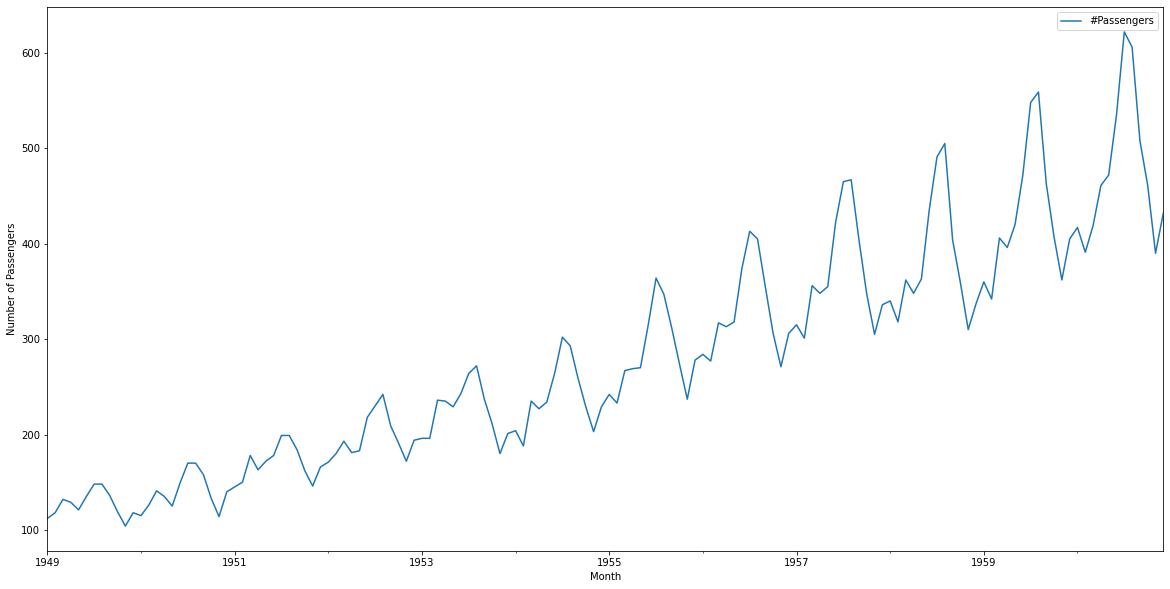

In [8]:
df.plot(figsize=(20,10))
plt.xlabel("Month")
plt.ylabel("Number of Passengers")
plt.show()

From observation, there is a strong seasonality, upward trend and increasing variance across the time. Let us plot the rolling average and variance on the graph.

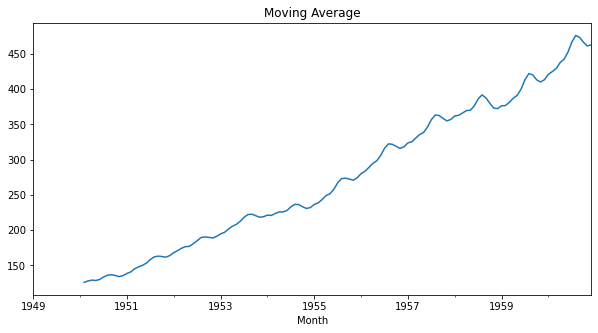

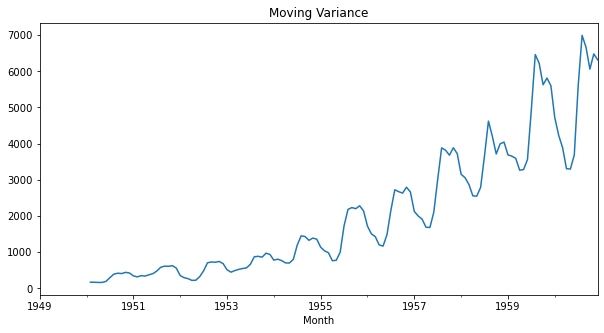

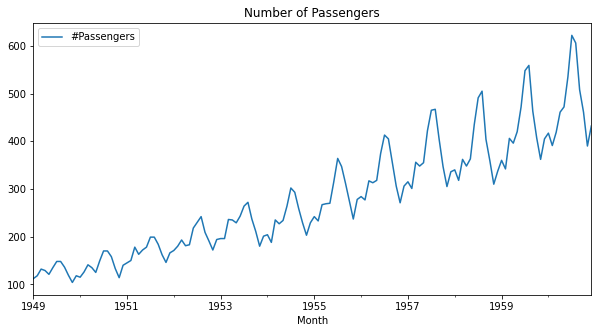

In [9]:
df.rolling(14).mean().plot(title="Moving Average", figsize=(10,5), legend=False)
df.rolling(14).var().plot(title="Moving Variance", figsize=(10,5), legend=False)
df.plot(title="Number of Passengers", figsize=(10,5))
plt.show()

To get a better understanding of our data we need to decompose it into different components.

### Practice ###
Perform seasonal decomposition on this data set.<br>
Which model would you choose to decompose the model? Multiplicative or Additive?

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [11]:
#perform decomposition
result = seasonal_decompose(df, model='multiplicative')

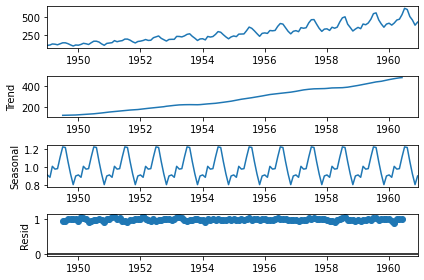

In [12]:
#plot results
result.plot()
plt.show()

From the analysis above, the data consists of string trend and consistent seasonality. Let us create a few models and look at how they perform.

## Moving Averages Forecasting

### Simple Exponential Moving Average

In [13]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing

In [14]:
ses = SimpleExpSmoothing(df['#Passengers'])

C:\Users\USER\miniconda3\envs\time-series-labs\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\USER\miniconda3\envs\time-series-labs\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


>`ValueWarning: No frequency information was provided, so inferred frequency MS will be used.` 
<br>

The warning appears because as we loaded our dataset in, `pandas` didn't automatically assign the frequency to index. From `df.index`, we can see that the `freq` (frequency) is `None`.

In [15]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

To fix this warning, we will set the frequency to the index.

In [16]:
df.index.freq = 'MS'

When we create the `SimpleExpSmoothing` object again, the error will be gone.

In [17]:
ses = SimpleExpSmoothing(df['#Passengers'])

In [18]:
result

Before we proceed to model the time series data, let us create a train test split. Here we will be using the last 12 data points as our test set.

In [19]:
test_n = 12
train = df['#Passengers'].iloc[:-test_n]
test = df['#Passengers'].iloc[-test_n:]

Now we will create 3 different variants of simple exponential smoothing:
1. In `fit_1`,  we do not use the auto optimization but instead choose to explicitly provide the model with $\alpha = 0.2$ parameter.
2. In `fit_2`, auto optimization does not apply as well but we choose $\alpha = 0.6$
3. In `fit_3`, we will let the model to find an optimized value of alpha for us. (Recommended approach)

We can specify the $\alpha$ value by parsing the value to `smoothing_level` in the `fit` method.

Note: If you ever curious about the `initialization_method`, it is not documented well in the official documentation but a user provided an answer which can be found [here](https://stats.stackexchange.com/questions/509772/what-do-the-values-for-initialization-method-mean-in-statsmodels-simple-exponent). The default `initialization_method` is `"estimated"`.

### Practice ###
Create 3 SimpleExpSmoothing models as stated above by calling `SimpleExpSmoothing`.

In [20]:
fit1 = SimpleExpSmoothing(train, initialization_method="heuristic").fit(smoothing_level=0.2,optimized=False)
fcast1 = fit1.forecast(test_n).rename(r'$\alpha=0.2$')

fit2 = SimpleExpSmoothing(train, initialization_method="heuristic").fit(smoothing_level=0.6,optimized=False)
fcast2 = fit2.forecast(test_n).rename(r'$\alpha=0.6$')

fit3 = SimpleExpSmoothing(train, initialization_method="estimated").fit()
fcast3 = fit3.forecast(test_n).rename(r'$\alpha=%s$'%fit3.model.params['smoothing_level'])

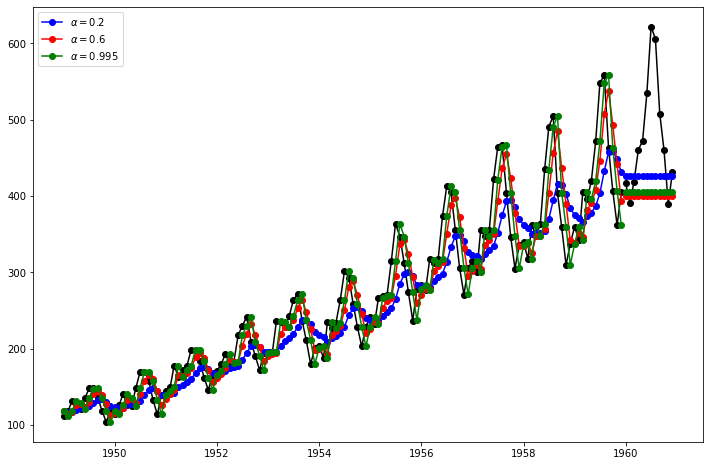

In [21]:
plt.figure(figsize=(12, 8))
plt.plot(train, marker='o', color='black')
plt.plot(test, marker='o', color='black')
plt.plot(fit1.fittedvalues, marker='o', color='blue')
line1, = plt.plot(fcast1, marker='o', color='blue')
plt.plot(fit2.fittedvalues, marker='o', color='red')
line2, = plt.plot(fcast2, marker='o', color='red')
plt.plot(fit3.fittedvalues, marker='o', color='green')
line3, = plt.plot(fcast3, marker='o', color='green')
plt.legend([line1, line2, line3], [fcast1.name, fcast2.name, fcast3.name])

The green line has the best fit to the training dataset. Let us check the summary of the result from `fit_3`.

In [22]:
fit3.summary()

Dep. Variable:,#Passengers,No. Observations:,132
Model:,SimpleExpSmoothing,SSE,129018.793
Optimized:,True,AIC,912.808
Trend:,None,BIC,918.574
Seasonal:,None,AICC,913.123
Seasonal Periods:,None,Date:,"Sun, 21 Mar 2021"
Box-Cox:,False,Time:,15:55:25
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9950000,alpha,True
initial_level,118.46667,l.0,True


What is the value of the alpha and what conclusion can you deduce from the value?

Remember that the simple exponential smoothing will only provide better forecasts on the time series that has **no trend
or seasonal component**. SES might not be working that well in this dataset.

### Holt's Method

We will create 3 Holt's models as follows:

1. In `fit1` we will fix the $\alpha$ and $\beta$ value to be 0.8 and 0.2 respectively without any optimization.
2. In `fit2` we will use Holt's damped trend and fix  $\alpha$ and $\beta$ value to be 0.8 and 0.2 respectively with dampened parameter $\phi$ left to be optimized.
3. In `fit3` we let the model to optimize $\alpha$, $\beta$ and $\phi$ values automatically.

### Practice ###
Create 3 Holt's models as stated above by calling `Holt`.

In [23]:
fit1 = Holt(train, initialization_method="estimated").fit(smoothing_level=0.8, smoothing_trend=0.2, optimized=False)
fcast1 = fit1.forecast(test_n).rename("Holt's linear trend")

fit2 = Holt(train, damped_trend=True, initialization_method="estimated").fit(smoothing_level=0.8, smoothing_trend=0.2)
fcast2 = fit2.forecast(test_n).rename("Additive damped trend")

fit3 = Holt(train, damped_trend=True, initialization_method="estimated").fit(optimized=True)
fcast3 = fit3.forecast(test_n).rename("Additive damped trend - Auto optimization")

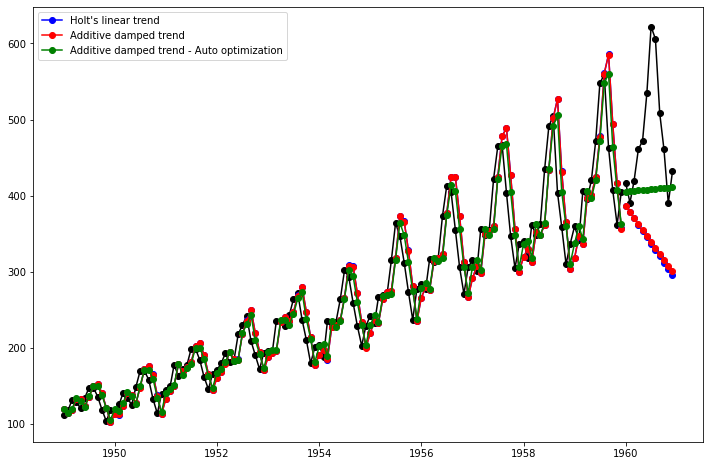

In [24]:
plt.figure(figsize=(12, 8))
plt.plot(train, marker='o', color='black')
plt.plot(test, marker='o', color='black')
plt.plot(fit1.fittedvalues, marker='o', color='blue')
line1, = plt.plot(fcast1, marker='o', color='blue')
plt.plot(fit2.fittedvalues, marker='o', color='red')
line2, = plt.plot(fcast2, marker='o', color='red')
plt.plot(fit3.fittedvalues, marker='o', color='green')
line3, = plt.plot(fcast3, marker='o', color='green')
plt.legend([line1, line2, line3], [fcast1.name, fcast2.name, fcast3.name])

In [25]:
fit3.summary()

Dep. Variable:,#Passengers,No. Observations:,132
Model:,Holt,SSE,128585.057
Optimized:,True,AIC,918.364
Trend:,Additive,BIC,932.778
Seasonal:,None,AICC,919.267
Seasonal Periods:,None,Date:,"Sun, 21 Mar 2021"
Box-Cox:,False,Time:,15:55:26
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9950000,alpha,True
smoothing_trend,0.0001,beta,True


## Holt-Winters Method

Here, we will create 4 different models to forecast the future.
We are setting the `seasonal_periods` explicitly to be 12 since we know that the data cycle is yearly and the frequency is of the data is monthly. We experiment on different configurations on trend and seasonal and see their effects on training and test errors.

4 models will be created namely:
1. `fit1` with additive trend and additive seasonality.
2. `fit2` with additive trend and multiplicative seasonality.
3. `fit3` with multiplicative trend and additive seasonality.
4. `fit4` with multiplicative trend and multiplicative seasonality.

### Practice ###
Create 4 models stated above by calling `ExponentialSmoothing`.

In [26]:
fit1 = ExponentialSmoothing(train, seasonal_periods=12, trend='add', seasonal='add').fit()
fcast1 = fit1.forecast(test_n).rename("trend-add_seasonal-add")

fit2 = ExponentialSmoothing(train, seasonal_periods=12, trend='add', seasonal='mul').fit()
fcast2 = fit2.forecast(test_n).rename("trend-add_seasonal-mul")

fit3 = ExponentialSmoothing(train, seasonal_periods=12, trend='mul', seasonal='add').fit()
fcast3 = fit3.forecast(test_n).rename("trend-mul_seasonal-add")

fit4 = ExponentialSmoothing(train, seasonal_periods=12, trend='mul', seasonal='mul').fit()
fcast4 = fit4.forecast(test_n).rename("trend-mul_seasonal-mul")

C:\Users\USER\miniconda3\envs\time-series-labs\lib\site-packages\statsmodels\tsa\holtwinters\model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


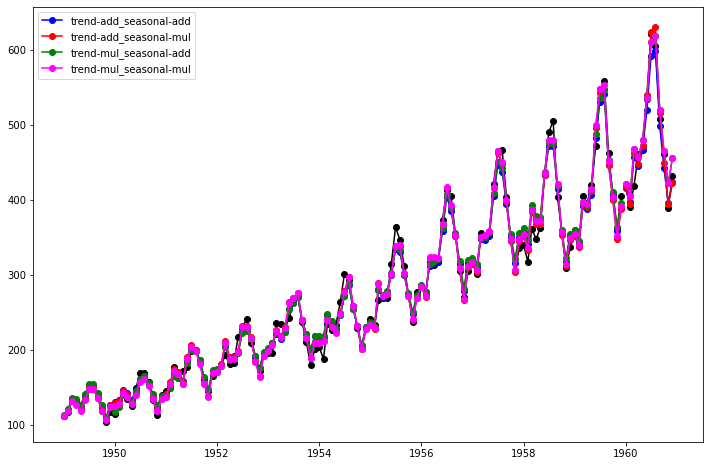

In [27]:
plt.figure(figsize=(12, 8))
plt.plot(train, marker='o', color='black')
plt.plot(test, marker='o', color='black')
plt.plot(fit1.fittedvalues, marker='o', color='blue')
line1, = plt.plot(fcast1, marker='o', color='blue')
plt.plot(fit2.fittedvalues, marker='o', color='red')
line2, = plt.plot(fcast2, marker='o', color='red')
plt.plot(fit3.fittedvalues, marker='o', color='green')
line3, = plt.plot(fcast3, marker='o', color='green')
plt.plot(fit4.fittedvalues, marker='o', color='magenta')
line4, = plt.plot(fcast3, marker='o', color='magenta')
plt.legend([line1, line2, line3, line4], [fcast1.name, fcast2.name, fcast3.name, fcast4.name])

Visually all models are doing good in predicting the test data. However, it would be great if we can find the errors of training set and test set.

### Practice ###

Create an RMSE function and find training and test errors of each model.

In [28]:
#create rmse function
def rmse(predicted_val, true):
    return np.sqrt(np.mean((predicted_val - true)**2))

Compare the values of each Holt-Winters methods by calculating the training set and test errors.

In [29]:
# Model 1 - additive trend, additive seasonality
train_error_1 = rmse(fit1.fittedvalues, train)
test_error_1 = rmse(fcast1, test)
print("Holt-Winters (additive trend, additive seasonality)")
print(f"Training set error: {train_error_1}, Test set error: {test_error_1}")

Holt-Winters (additive trend, additive seasonality)
Training set error: 11.62469954262423, Test set error: 16.98114161550258


In [30]:
# Model 2 - additive trend, multiplicative seasonality
train_error_2 = rmse(fit2.fittedvalues, train)
test_error_2 = rmse(fcast2, test)
print("Holt-Winters (additive trend, multiplicative seasonality)")
print(f"Training set error: {train_error_2}, Test set error: {test_error_2}")

Holt-Winters (additive trend, multiplicative seasonality)
Training set error: 9.768020481856626, Test set error: 15.809890178532703


In [31]:
# Model 3 - multiplicative trend, additive seasonality
train_error_3 = rmse(fit3.fittedvalues, train)
test_error_3 = rmse(fcast3, test)
print("Holt-Winters (multiplicative trend, additive seasonality)")
print(f"Training set error: {train_error_3}, Test set error: {test_error_3}")

Holt-Winters (multiplicative trend, additive seasonality)
Training set error: 11.671459037171296, Test set error: 19.94862742675839


In [32]:
# Model 4 - multiplicative trend, additive seasonality
train_error_4 = rmse(fit4.fittedvalues, train)
test_error_4 = rmse(fcast4, test)
print("Holt-Winters (multiplicative trend, multiplicative seasonality)")
print(f"Training set error: {train_error_4}, Test set error: {test_error_4}")

Holt-Winters (multiplicative trend, multiplicative seasonality)
Training set error: 9.617924831716339, Test set error: 25.81135901063159
